<a href="https://colab.research.google.com/github/basel5621/DEPI-Customer-Sentiment-and-Trend-Analysis/blob/main/Training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the environment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense ,Dropout
from tensorflow.keras import layers
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Attention
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MultiHeadAttention

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Loading dataset

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1v27NO9YEz4AXY_rGskbtIqPsgIY_CRTo' -O train1.csv

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QpvtoxF85kPr95Vg6XDbSguql6dXEjJS' -O train2.csv

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UF38afygeHSN0ZOMaMCQlKy6QDnwnyXu' -O train3.csv


--2024-10-11 07:22:17--  https://docs.google.com/uc?export=download&id=1v27NO9YEz4AXY_rGskbtIqPsgIY_CRTo
Resolving docs.google.com (docs.google.com)... 142.250.141.139, 142.250.141.102, 142.250.141.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.141.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1v27NO9YEz4AXY_rGskbtIqPsgIY_CRTo&export=download [following]
--2024-10-11 07:22:17--  https://drive.usercontent.google.com/download?id=1v27NO9YEz4AXY_rGskbtIqPsgIY_CRTo&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.101.132, 2607:f8b0:4023:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.101.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39529308 (38M) [application/octet-stream]
Saving to: ‘train1.csv’

train1.csv          100%[===================>]  37.70M  28.7MB/s   

In [ ]:
df1 = pd.read_csv('train1.csv')
df2 = pd.read_csv('train2.csv')
df3 = pd.read_csv('train3.csv')

In [ ]:
df1.head()

,cleaned_text,label
0,already tested blood 1947 long game ethnic cle...,1.0
1,yep thats hate bad,0.0
2,dream,1.0
3,uk first past post electoral system broken lea...,0.0
4,excited welcome one newest member team michell...,1.0


In [ ]:
df2.head()

,cleaned_text,label
0,going another signing north cause live blackpo...,0
1,cowardly loser seek racism weapon not win,1
2,checking much talked twitter thanks jen,1
3,feel hot im kind getty coughy scratchy throat,0
4,yay emily twitter exciting hope summer going w...,1


In [ ]:
df3.drop(['Unnamed: 0'], axis=1, inplace=True)
df3.head()

,processed_review,label
0,spectacular horror movie give chill get settle...,1
1,one level film bring child u want build sandca...,1
2,think many film especially comedy added memora...,1
3,first came work meysels brother much criticize...,1
4,advent imdb overlooked movie find interested a...,1


# Preprocessing data for analysis

In [ ]:
# Rename columns if needed
df1 = df1.rename(columns={'cleaned_text': 'text'})
df2 = df2.rename(columns={'cleaned_text': 'text'})
df3 = df3.rename(columns={'processed_review': 'text'})

df1.shape, df2.shape, df3.shape

((441353, 2), (1440000, 2), (50000, 2))

## Sampling 40% of dataset2

In [ ]:
df22=df2.sample(frac=0.4, random_state=42).reset_index(drop=True)

In [ ]:
df22.shape ,df2.shape

((576000, 2), (1440000, 2))

In [ ]:
df1.shape, df2.shape, df3.shape

((441353, 2), (1440000, 2), (50000, 2))

## combine the three dataset

In [ ]:
# Concatenate the datasets
combined_df = pd.concat([df1[['text', 'label']], df22[['text', 'label']], df3[['text', 'label']]], ignore_index=True)
combined_df.head()

,text,label
0,already tested blood 1947 long game ethnic cle...,1.0
1,yep thats hate bad,0.0
2,dream,1.0
3,uk first past post electoral system broken lea...,0.0
4,excited welcome one newest member team michell...,1.0


In [ ]:
combined_df.shape

(1067353, 2)

## Describing word count statistics

In [ ]:
combined_df['wordcount'] =combined_df['text'].astype(str).apply(lambda x: len(x.split()))
combined_df.head()

,text,label,wordcount
0,already tested blood 1947 long game ethnic cle...,1.0,17
1,yep thats hate bad,0.0,4
2,dream,1.0,1
3,uk first past post electoral system broken lea...,0.0,24
4,excited welcome one newest member team michell...,1.0,19


[(4, 78865), (5, 78813), (6, 76174), (3, 73985), (7, 70365), (8, 64698), (2, 59772), (9, 59691), (10, 54914), (11, 49724), (12, 44998), (13, 39135), (14, 32862), (1, 27392), (15, 26391), (16, 21347), (17, 17507), (18, 14754), (19, 13375), (20, 12554), (21, 12548), (23, 12438), (22, 12388), (24, 12266), (25, 11439), (26, 10115), (27, 8660), (28, 7102), (29, 4978), (30, 3679), (31, 2585), (32, 1788), (33, 1126), (34, 784), (65, 679), (64, 668), (68, 660), (63, 642), (62, 640), (61, 620), (67, 612), (69, 609), (66, 606), (70, 601), (60, 592), (59, 561), (71, 552), (73, 552), (72, 549), (35, 539)]


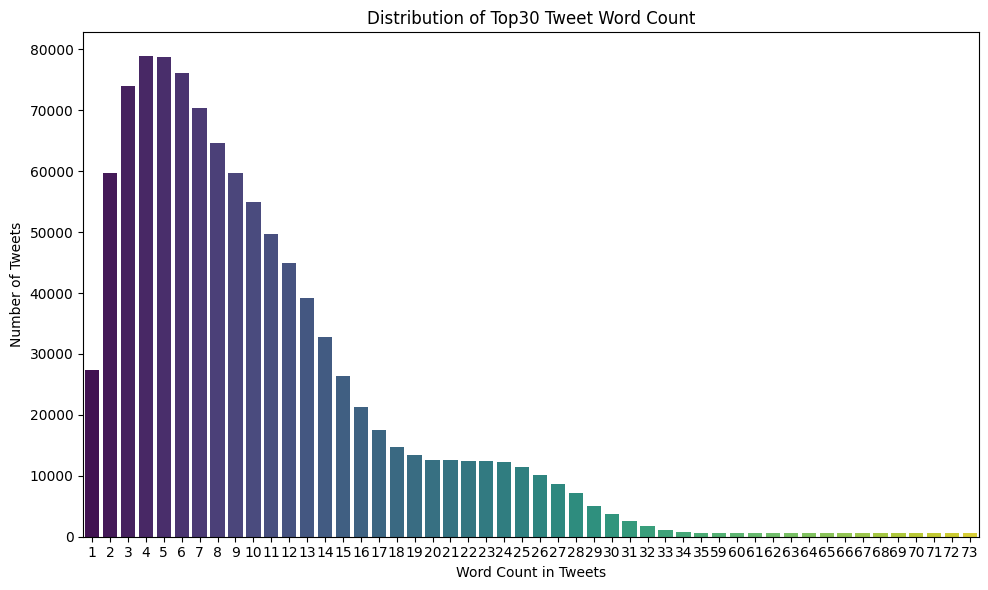

In [ ]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
# Add a new column for word count in each tweet
word_count =combined_df['text'].astype(str).apply(lambda x: len(x.split()))

word_count_freq = Counter(word_count)
common_word_count = word_count_freq.most_common(50)
print(common_word_count)
common_word_count.sort(key=lambda x: x[0])
label=[l  for l , _ in common_word_count]
count=[c  for _ , c in common_word_count]


plt.figure(figsize=(10, 6))
sns.barplot(x=label, y=count, palette="viridis")
plt.title('Distribution of Top30 Tweet Word Count')
plt.xlabel('Word Count in Tweets')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
combined_df['wordcount'].describe()

,wordcount
count,1067353.00
mean,15.03
std,31.31
min,1.00
25%,5.00
50%,9.00
75%,14.00
max,1437.00


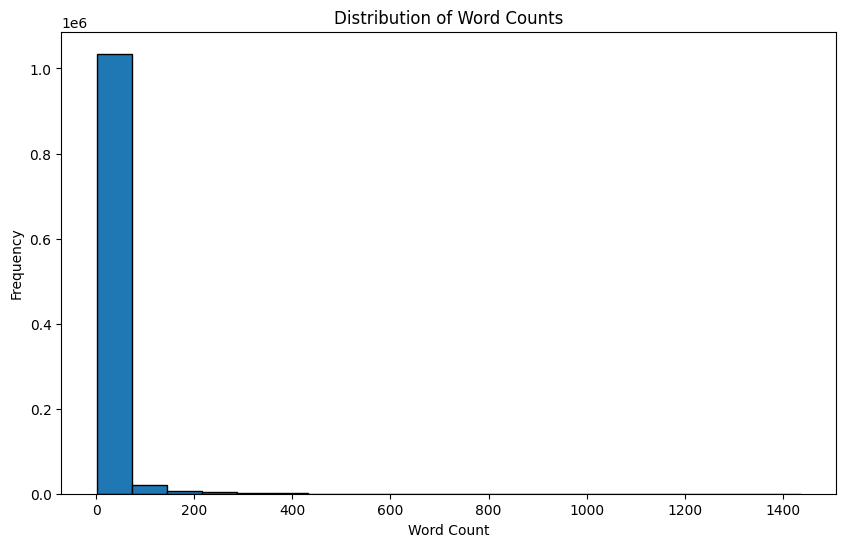

In [ ]:
import matplotlib.pyplot as plt

# Assuming df contains the wordcount column after filtering
plt.figure(figsize=(10, 6))
plt.hist(combined_df['wordcount'], bins=20, edgecolor='black')
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## Limiting word count to 50

In [ ]:
df=combined_df[combined_df['wordcount'] <= 50]
df.shape, combined_df.shape

((1023227, 3), (1067353, 3))

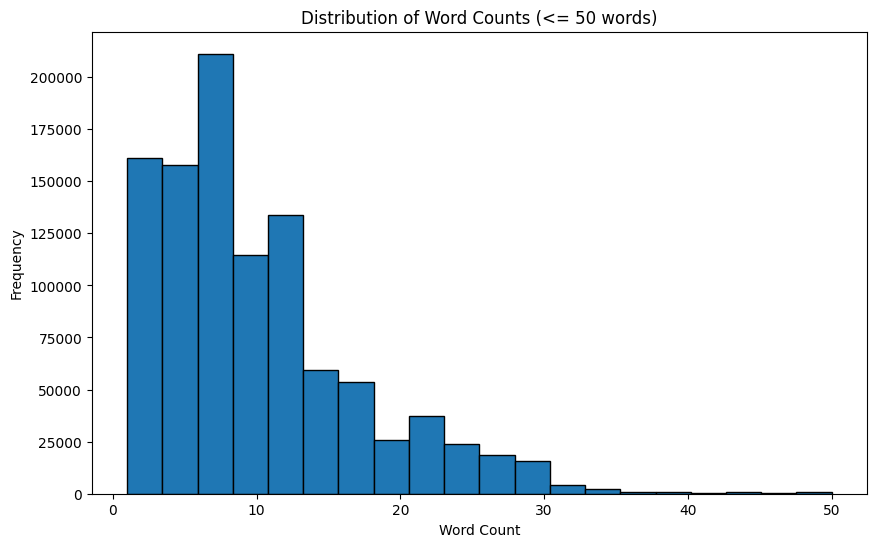

In [ ]:
import matplotlib.pyplot as plt

# Assuming df contains the wordcount column after filtering
plt.figure(figsize=(10, 6))
plt.hist(df['wordcount'], bins=20, edgecolor='black')
plt.title('Distribution of Word Counts (<= 50 words)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


## Plotting label distribution

In [ ]:
label_distribution = df['label'].value_counts()

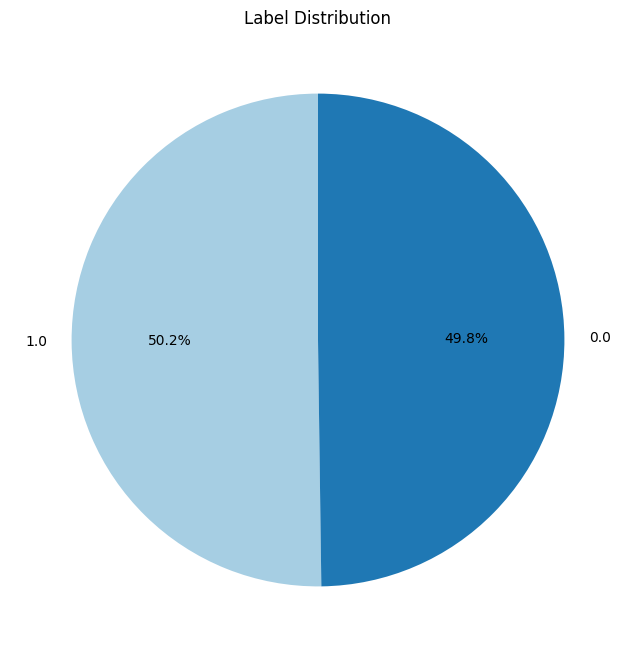

In [ ]:

plt.figure(figsize=(8, 8))  # Adjust the figure size if needed

plt.pie(label_distribution,
        labels=label_distribution.index,  # Labels for the pie sections
        autopct='%1.1f%%',                # Display percentages
        startangle=90,                    # Start angle for better orientation
        colors=plt.cm.Paired.colors)      # Optional: Use a color map

plt.title('Label Distribution')

plt.show()


In [ ]:
# Shuffle the combined dataset
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.drop(['wordcount'], axis=1, inplace=True)
df.head()

,text,label
0,different subject sport used love playing tenn...,0.00
1,reeeal long walk sf dont feel leg afterjavaone,1.00
2,yugos not chinese company car made zastava fia...,1.00
3,going boss bmw,0.00
4,perfect corrupt indeed,1.00


## Detecting non-ASCII characters

In [ ]:
df['text']=df['text'].astype(str)

In [ ]:
# Function to check if a text contains only ASCII characters
def is_ascii(text):
    return all(ord(char) < 128 for char in text)

# Apply the function to detect non-ASCII rows
df['is_ascii'] = df['text'].apply(is_ascii)

# Filter out non-ASCII rows
df_clean = df[df['is_ascii']]
df_dirt = df[~df['is_ascii']]

# Display the cleaned dataset
df_dirt.head()

,text,label,is_ascii
202,𝑲𝒏𝒐𝒘𝒍𝒆𝒅𝒈𝒆 𝒔𝒆𝒆𝒌𝒔 𝒏𝒐 𝒎𝒂𝒏 yvellia vernalis archon...,1.00,False
398,cullencoven â janine charmaine martel commente...,1.00,False
517,quotalways gon na hill battle sometimes iâm go...,0.00,False
719,ive seen yma6 yesterday bayside amp nfg guy ro...,0.00,False
979,team excited cooperation amp look forward disc...,1.00,False


In [ ]:
df_dirt.shape

(7760, 3)

In [ ]:
# Drop the 'is_ascii' column used for filtering
df_clean = df_clean.drop(columns=['is_ascii'])

# Reset index after cleaning
df_clean = df_clean.reset_index(drop=True)

# Display the cleaned dataset
df_clean.shape

(1015467, 2)

## spliting the data

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset
train_df, test_df = train_test_split(df_clean, test_size=0.4, random_state=42)

train_df.shape, test_df.shape

((609280, 2), (406187, 2))

In [ ]:
# df_train.to_csv('train.csv',index=False)

In [ ]:
# test_df.to_csv('test.csv',index=False)

In [ ]:
X=train_df['text'].astype(str)
y=train_df['label']

X.info()

<class 'pandas.core.series.Series'>
Index: 609280 entries, 58273 to 121958
Series name: text
Non-Null Count   Dtype 
--------------   ----- 
609280 non-null  object
dtypes: object(1)
memory usage: 9.3+ MB


# Training Word2Vec model

In [ ]:
X_token=X.apply(word_tokenize)
model_w2v = Word2Vec(X_token, vector_size=100, window=5, min_count=3, workers=8, sg=0)

In [ ]:
print(model_w2v.wv.most_similar('happy'))

[('happiest', 0.5602237582206726), ('thankful', 0.5531660318374634), ('bash', 0.5154563784599304), ('heppy', 0.5145349502563477), ('celebrating', 0.505530059337616), ('proud', 0.5023665428161621), ('blessed', 0.49245405197143555), ('celebrate', 0.48851028084754944), ('raye', 0.4859510362148285), ('sadmy', 0.4800211787223816)]


In [ ]:
print(model_w2v.wv.most_similar('love'))

[('loved', 0.6096282601356506), ('lt3', 0.6075996160507202), ('adore', 0.5744768381118774), ('amazing', 0.5669606328010559), ('beautiful', 0.5248692035675049), ('luv', 0.5193105936050415), ('lover', 0.5070039629936218), ('sing', 0.4871593713760376), ('loving', 0.47940754890441895), ('precious', 0.4790411591529846)]


In [ ]:
model_w2v.save("combined_dataset_word2vec.bin")

In [ ]:
loaded_model = Word2Vec.load("combined_dataset_word2vec.bin")

# Converting text to sequences

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

vocab_size = len(tokenizer.word_index)+1

X_train_seq = tokenizer.texts_to_sequences(X)

max_len = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq , maxlen=max_len , padding='post')
vocab_size

234745

In [ ]:
max_len

54

In [ ]:
X_train_padded.shape

(609280, 54)

# Creating embedding matrix

In [ ]:
embedding_dim = model_w2v.vector_size  # 300 in your case
embedding_matrix = np.zeros((vocab_size, model_w2v.vector_size))
for word, i in tokenizer.word_index.items():
    if word in model_w2v.wv:
        embedding_matrix[i] = model_w2v.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

In [ ]:
embedding_matrix.shape

(234745, 100)

# saving

In [ ]:
import pickle
with open('tokenizer5.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
np.save('X_train_padded.npy', X_train_padded)

In [ ]:
np.save('y.npy', y.to_numpy())

In [ ]:
np.save('embedding_matrix.npy', embedding_matrix)

In [ ]:
import os

# Get the file size in bytes
file_size = os.path.getsize('X_train_padded.npy')

# Convert to megabytes (optional)
file_size_MB = file_size / (1024 * 1024)

print(f"File size: {file_size_MB:.2f} MB")


File size: 388.76 MB


In [ ]:
import os

# Get the file size in bytes
file_size = os.path.getsize('embedding_matrix.npy')

# Convert to megabytes (optional)
file_size_MB = file_size / (1024 * 1024)

print(f"File size: {file_size_MB:.2f} MB")

File size: 793.49 MB


# training models

## GRU Model

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
model = models.Sequential([
    layers.Input(shape=(max_len,)),
    layers.Embedding(input_dim=vocab_size, output_dim=model_w2v.vector_size, weights=[embedding_matrix], trainable=False),
    layers.Bidirectional(layers.GRU(256, return_sequences=True)),
    layers.BatchNormalization(),
    layers.GlobalMaxPool1D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

model.compile(optimizer=Adam(learning_rate=0.0005),
               loss='binary_crossentropy',
               metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 54, 100)             │      23,474,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 54, 512)             │         549,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 54, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 512)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,092,741 (91.91 MB)

 Trainable params: 616,961 (2.35 MB)

 Non-trainable params: 23,475,780 (89.55 MB)

In [ ]:
history = model.fit(X_train_padded, y, epochs=100, batch_size=512, validation_split=0.1,callbacks=[early_stopping,lr_schedule])

Epoch 1/100
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 75s 67ms/step - accuracy: 0.7944 - loss: 0.5931 - val_accuracy: 0.8538 - val_loss: 0.3693 - learning_rate: 5.0000e-04
Epoch 2/100
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 69s 65ms/step - accuracy: 0.8527 - loss: 0.3529 - val_accuracy: 0.8595 - val_loss: 0.3157 - learning_rate: 5.0000e-04
Epoch 3/100
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 80s 63ms/step - accuracy: 0.8606 - loss: 0.3143 - val_accuracy: 0.8626 - val_loss: 0.3051 - learning_rate: 5.0000e-04
Epoch 4/100
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.8643 - loss: 0.3021 - val_accuracy: 0.8653 - val_loss: 0.2993 - learning_rate: 5.0000e-04
Epoch 5/100
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.8688 - loss: 0.2942 - val_accuracy: 0.8655 - val_loss: 0.2983 - learning_rate: 5.0000e-04
Epoch 6/100
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.8711 - loss: 0.2887 - val_accuracy: 0.8683 - val_loss: 0.2933 - learning_rate: 5.0000e-04
Epoch 7/100
1071/1071 ━━━━━━━━━━━━

<Axes: >

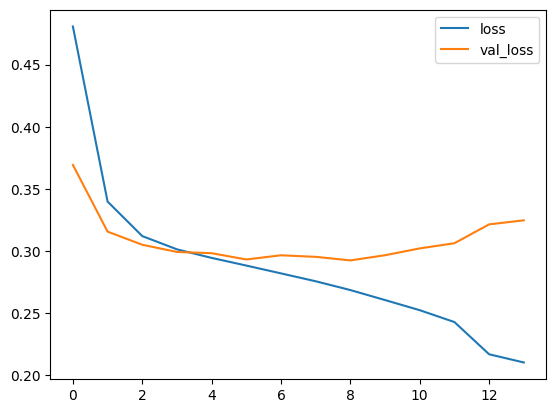

In [ ]:
df_hist=pd.DataFrame(history.history)
df_hist[['loss','val_loss']].plot()

<Axes: >

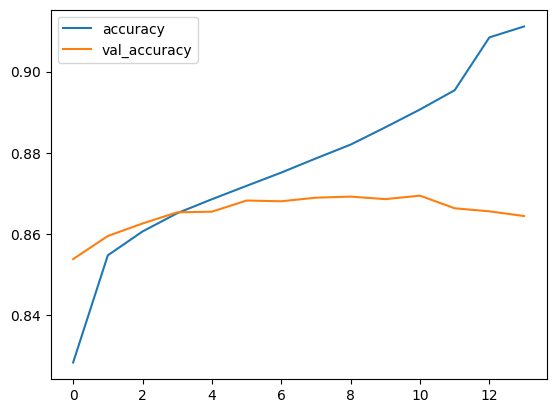

In [ ]:
df_hist[['accuracy','val_accuracy']].plot()

In [ ]:
model.save("Final_Model.keras")

# Testing

In [ ]:
def myscore(X,y,model,tokenizer=tokenizer,maxlen=54):
  X_seq=tokenizer.texts_to_sequences(X.tolist())
  X_padded=pad_sequences(X_seq,maxlen=maxlen,padding='post')
  loss,acc=model.evaluate(X_padded,y)
  return loss,acc

def predict_sentiment(sentence, model , tokenizer=tokenizer, max_len=54):

    sequences = tokenizer.texts_to_sequences([sentence])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)

    prediction = model.predict(padded_sequences,verbose=0)
    print(f"Prediction: {prediction[0][0]}")
    if prediction >= 0.5:
        return "Positive"
    else:
        return "Negative"

In [ ]:
X_test=test_df['text']
y_test=test_df['label']

# Test model5

In [ ]:
loss,acc = myscore(X_test , y_test , model=model)
print(f'loss={loss},accuracy={acc*100}')

12694/12694 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - accuracy: 0.8705 - loss: 0.2916
loss=0.2929137945175171,accuracy=86.94763779640198


In [ ]:
predict_sentiment("i love ai", model=model) #

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: 0.5455936789512634


'Positive'

In [ ]:
predict_sentiment("i hate ai", model=model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction: 0.6169846057891846


'Positive'

In [ ]:
predict_sentiment("i very happy", model=model) #

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction: 0.4335774779319763


'Negative'

In [ ]:
predict_sentiment("This is the best movie I've seen in years!", model=model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: 0.8536403179168701


'Positive'

In [ ]:
predict_sentiment("I absolutely hate how slow this service is.", model=model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction: 0.5579270720481873


'Positive'

In [ ]:
# Sample list of customer feedback
feedbacks = [
    "The product quality is amazing, I love it!",
    "I'm not satisfied with the customer support.",
    "This is the best service I've used in a while.",
    "The delivery took too long, very disappointed.",
    "The price is reasonable, but the quality could be better.",
    "Excellent experience! Will definitely recommend.",
    "Terrible customer service, will not come back.",
    "I'm neutral about the product. It's okay, not great.",
    "I absolutely hate how slow this service is.",
    "Very efficient and quick response. Highly satisfied!"
]

# Function to predict sentiment
def predict_sentiments(feedback_list, model):
    for feedback in feedback_list:
        sentiment = predict_sentiment(feedback, model=model)  # Assuming predict_sentiment() is already defined
        print(f"Feedback: {feedback}\nPredicted Sentiment: {sentiment}\n")

# Assuming 'model' is your pre-trained sentiment analysis model
predict_sentiments(feedbacks, model=model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: 0.5552890300750732
Feedback: The product quality is amazing, I love it!
Predicted Sentiment: Positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: 0.36861148476600647
Feedback: I'm not satisfied with the customer support.
Predicted Sentiment: Negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: 0.8680256009101868
Feedback: This is the best service I've used in a while.
Predicted Sentiment: Positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction: 0.5393097996711731
Feedback: The delivery took too long, very disappointed.
Predicted Sentiment: Positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: 0.4177597761154175
Feedback: The price is reasonable, but the quality could be better.
Predicted Sentiment: Negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction: 0.8449246287345886
Feedback: Excellent experience! Will definitely recommend.
Predicted Sentiment: Positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: 

## Classification report and confusion matrix

In [ ]:
def Predict2(X,y):
  X_seq=tokenizer.texts_to_sequences(X.tolist())
  X_padded=pad_sequences(X_seq,maxlen=max_len,padding='post')

  y_pred = model.predict(X_padded)
  return y_pred

In [ ]:
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred):
    y_pred_rounded = np.round(y_pred)
    report = classification_report(y_true, y_pred_rounded, target_names=['Negative', 'Positive'])
    print(report)

y_pred = Predict2(X_test,y_test)
print_classification_report(y_test, y_pred)

12694/12694 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step
              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87    202388
    Positive       0.87      0.87      0.87    203799

    accuracy                           0.87    406187
   macro avg       0.87      0.87      0.87    406187
weighted avg       0.87      0.87      0.87    406187



In [ ]:
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(y_true, y_pred):
    y_pred_rounded = np.round(y_pred)
    cm = confusion_matrix(y_true, y_pred_rounded)
    return cm

def plot_confusion_matrix(cm, labels=['Negative', 'Positive']):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()


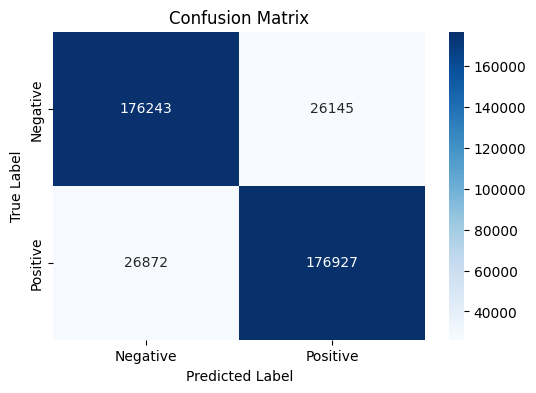

In [ ]:
cm=compute_confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)